# KoLesky Test Suite

Testing the effect of different parameter (rho, neighbors, N) values on accuracy vs speed


### Imports and functions to interface with the KoLesky library

In [34]:
include("/home/pietaril/Documents/MI-AIM/julia/KoLesky.jl-master/src/KoLesky.jl")

using Random
using Plots
using StatsPlots
using Statistics
using StatsBase
using Distances
using DataFrames
using LinearAlgebra
using NCDatasets

# ************************************** #
# Functions for example kernel modeling  #
# ************************************** #

# Square exponential kernel
function spherical_sqexp(d::T; logθ::AbstractVector{T}) where T <: Real
    exp(logθ[1]) * exp(-.5d^2 / (exp(logθ[2]) .^ 2))
end

# Matern 3/2 kernel
function Matern32(d::T; logθ::AbstractVector{T}) where T <: Real
    h = sqrt(3)*d / exp(logθ[2]) # d is Euclidean distance
    exp(logθ[1]) * (1. + h) * exp(-h)
end

# Function for computing kernel of new location vs training data
function kernel_matrix(X::Array{T}, l::Vector{T},  k::Function) where T
    d = pairwise(Euclidean(), X')
    k.(d; logθ = [0.0; l])
end

#*****************#
# Maija's helpers #
#*****************#


function compute_explicit_factor(x::Array{T}, K::Array{T}, rho, neighbors) where T <: Real
    #returns ExplicitKLFactorization explicit_factor 
    measurements = KoLesky.point_index_measurements(x)
    G = KoLesky.MatrixCovariance(K)
    implicit_factor = KoLesky.ImplicitKLFactorization(G, measurements, rho, neighbors)
    explicit_factor = KoLesky.ExplicitKLFactorization(implicit_factor)
    return explicit_factor
end    
    

function assemble_inv_covariance(factor::KoLesky.ExplicitKLFactorization)
    #returns approximation of the inverse of K
    U_matrix = Matrix(factor.U)
    inv_P = similar(factor.P)
    inv_P[factor.P] = 1 : length(inv_P)

    return (U_matrix * U_matrix')[inv_P, inv_P]
end 


function make_PD!(K::Array{T}, a::T) where T
    # Make input matrix positive definite by adding the identity matrix I multiplied with a small constant. 
    K = K + a*I
    return K
end

function read_cov_from_file(filepath::String)
    ds = Dataset(filepath);
    K = ds["covariance"][:,:];
    #julia thinks K still contains missing values, convert the type
    K = convert(Array{Float64}, K)
    lon = ds["lon"][:];
    lat = ds["lat"][:];
    close(ds);
    x = [lat'; lon'];
    x = convert(Array{Float64}, x)

    return K, x
end

function KL_invert(x::Array{T}, K::Array{T}, rho, neighbors) where T <: Real
    factor = compute_explicit_factor(x, K, rho, neighbors)
    iK_approx = assemble_inv_covariance(factor);
    
    return iK_approx
end

function KL_invert_prealloc(x::Array{T}, K::Array{T}, rho, neighbors) where T <: Real
    
    factor = compute_explicit_factor(x, K, rho, neighbors)
    K = assemble_inv_covariance(factor);
    
    return K
end


KL_invert! (generic function with 1 method)

1

# With existing cov matrix

In [41]:
filepath = "/home/pietaril/Documents/data/CO2M_testdata/unc_cov_matrices/unc_cov_matrix20250609_nanmedian_small.nc";

ds = Dataset(filepath);

K, x = read_cov_from_file(filepath)


([2.35903128825157e-9 2.35903128825157e-9 … 2.35903128825157e-9 2.35903128825157e-9; 2.35903128825157e-9 2.35903128825157e-9 … 2.35903128825157e-9 2.35903128825157e-9; … ; 2.35903128825157e-9 2.35903128825157e-9 … 2.35903128825157e-9 2.35903128825157e-9; 2.35903128825157e-9 2.35903128825157e-9 … 2.35903128825157e-9 2.35903128825157e-9], [73.49718475341797 73.55016326904297 … -54.24047088623047 -54.21207046508789; 159.66041564941406 159.91659545898438 … -10.452719688415527 -10.600675582885742])

In [3]:
K

8208×8208 Matrix{Float64}:
 2.35903e-9  2.35903e-9  2.35903e-9  …  2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9  …  2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 ⋮                                   ⋱  ⋮                       
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9  …  2.35903e-9  2.35903e-9  2.35903e-9
 2.35903

In [42]:
#println(minimum(abs.(K)))
#a = minimum(abs.(K))
a = 1e-16
K = make_PD!(K, a)

8208×8208 Matrix{Float64}:
 2.35903e-9  2.35903e-9  2.35903e-9  …  2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9  …  2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 ⋮                                   ⋱  ⋮                       
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9  …  2.35903e-9  2.35903e-9  2.35903e-9
 2.35903

In [22]:
K

8208×8208 Matrix{Float64}:
 2.35903e-9  2.35903e-9  2.35903e-9  …  2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9  …  2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 ⋮                                   ⋱  ⋮                       
 2.35903e-9  2.35903e-9  2.35903e-9     2.35903e-9  2.35903e-9  2.35903e-9
 2.35903e-9  2.35903e-9  2.35903e-9  …  2.35903e-9  2.35903e-9  2.35903e-9
 2.35903

In [38]:
rho = 8
neighbors = 9

#factor = compute_explicit_factor(x, K, rho, neighbors)
@time iK_approx = KL_invert(x, K, rho, neighbors)


[multithreading] using 4 threads


  4.828152 seconds (13.47 M allocations: 3.358 GiB, 2.36% gc time)


8208×8208 Matrix{Float64}:
  1.01722e16   1.72182e14  -2.09972e12  …  -3.00213e13  -3.00213e13
  1.72182e14   1.01722e16  -2.09972e12     -3.00213e13  -3.00213e13
 -2.09972e12  -2.09972e12   9.9979e15       0.0          0.0
  1.72182e14   1.72182e14  -2.09972e12     -3.00213e13  -3.00213e13
 -3.39424e13  -3.39424e13  -3.39424e13      0.0          0.0
  2.79721e12   2.79721e12   2.79723e12  …   0.0          0.0
  1.06809e12   1.06809e12  -2.09972e12      0.0          0.0
  1.72182e14   1.72182e14  -2.09972e12     -3.00213e13  -3.00213e13
 -1.46244e13  -1.46244e13  -1.46244e13      0.0          0.0
 -3.38162e13  -3.38162e13  -3.38162e13      0.0          0.0
  ⋮                                     ⋱               
  0.0          0.0          0.0            -4.19149e13  -4.19149e13
  0.0          0.0          0.0         …  -2.15526e13  -2.15526e13
 -3.00212e13  -3.00212e13   0.0             1.94012e14   1.94012e14
 -3.00213e13  -3.00213e13   0.0             1.94012e14   1.94012e14
 -3.00

In [11]:
@time iK = inv(K)

684.281788 seconds (6 allocations: 8.375 GiB, 0.21% gc time)


33495×33495 Matrix{Float64}:
  1.00000e16  -1.59928e9   -1.59928e9  …  -1.60395e9   -1.60395e9  -1.60395e9
 -1.59846e9    1.00000e16  -1.60321e9     -1.61817e9   -1.61817e9  -1.61817e9
 -1.6006e9    -1.60535e9    1.0e16        -1.60395e9   -1.60395e9  -1.60395e9
 -1.6006e9    -1.60535e9   -1.60535e9     -1.60395e9   -1.60395e9  -1.60395e9
 -1.6006e9    -1.60535e9   -1.60535e9     -1.60395e9   -1.60395e9  -1.60395e9
 -1.6006e9    -1.60535e9   -1.60535e9  …  -1.60395e9   -1.60395e9  -1.60395e9
 -1.6006e9    -1.60535e9   -1.60535e9     -1.60395e9   -1.60395e9  -1.60395e9
 -1.6006e9    -1.60535e9   -1.60535e9     -1.60395e9   -1.60395e9  -1.60395e9
 -1.6006e9    -1.60535e9   -1.60535e9     -1.60395e9   -1.60395e9  -1.60395e9
 -1.6006e9    -1.60535e9   -1.60535e9     -1.60395e9   -1.60395e9  -1.60395e9
  ⋮                                    ⋱                           
 -1.60046e9   -1.60521e9   -1.60521e9     -1.60521e9   -1.60521e9  -1.60521e9
 -1.60046e9   -1.60521e9   -1.60521e9     -1.

[multithreading] using 4 threads


  5.008043 seconds (13.47 M allocations: 3.358 GiB, 1.85% gc time)


In [ ]:
factor = compute_explicit_factor(x, K, rho, neighbors)
U_approx = factor.U
P = factor.P
C = cholesky(K[P, P])
U = inv(C.U)
abs_err = norm(U.-U_approx) #Frobenius norm
rel_err = abs_err/norm(U)

In [31]:
iK_approx = assemble_inv_covariance(factor);
iK = inv(K);
norm(iK.-iK_approx)/norm(iK)

0.03918992111166088

## With matrices created from covariance functions


In [2]:


function param_variation_test(Ns::AbstractVector{T}, rhos::AbstractVector{T}, neighborss::AbstractVector{T}) where T<:Real
    # Tests for timing Cholesky of Matern32 with l = [0.001]. Need to adjust this later to take also k and l as inputs so that they can also vary.
    # For some reason passing a funktion k didn't work
    results = DataFrame()
    l = [0.001]
    k = Matern32
    i = 0
    for N in Ns
        for rho in rhos
            for neighbors in neighborss
                    i += 1
                    x = rand(2, N);
                    K = kernel_matrix(x'[:,:],l,k);
                    t = @elapsed compute_explicit_factor(x, K, rho, neighbors)
                    push!(results, (id = i, N = N, rho = rho, n_neighbors = neighbors, time = t))
                
            end
        end
    end
    return results

end

param_variation_test (generic function with 1 method)

In [4]:
Ns = [1000, 5000, 10^4, 15000, 2*10^4]
neighborss = 4:12
rhos = 2:8


df = param_variation_test(Ns, rhos, neighborss)

[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


Row,id,N,rho,n_neighbors,time
,Int64,Int64,Int64,Int64,Float64
1,1,1000,2,4,3.1313
2,2,1000,2,5,0.0895502
3,3,1000,2,6,0.0740382
4,4,1000,2,7,0.0747126
5,5,1000,2,8,0.0587044
6,6,1000,2,9,0.0613744
7,7,1000,2,10,0.0626568
8,8,1000,2,11,0.068608
9,9,1000,2,12,0.0792929


Write to CSV-file

In [16]:
using CSV
CSV.write("out.csv", df)

"out.csv"

Read from CSV.file

In [24]:
df = DataFrame(CSV.File("out.csv"))

Row,id,N,rho,n_neighbors,time
,Int64,Int64,Int64,Int64,Float64
1,1,1000,2,4,3.1313
2,2,1000,2,5,0.0895502
3,3,1000,2,6,0.0740382
4,4,1000,2,7,0.0747126
5,5,1000,2,8,0.0587044
6,6,1000,2,9,0.0613744
7,7,1000,2,10,0.0626568
8,8,1000,2,11,0.068608
9,9,1000,2,12,0.0792929


In [26]:
gdf_rho = groupby(df, :rho)
gdf_neighbors = groupby(df, :n_neighbors)

Row,id,N,rho,n_neighbors,time
,Int64,Int64,Int64,Int64,Float64
1,1,1000,2,4,3.1313
2,10,1000,3,4,0.0497214
3,19,1000,4,4,0.0618131
4,28,1000,5,4,0.0823541
5,37,1000,6,4,0.0916111
6,46,1000,7,4,0.112047
7,55,1000,8,4,0.125567
8,64,5000,2,4,0.219511
9,73,5000,3,4,0.332447


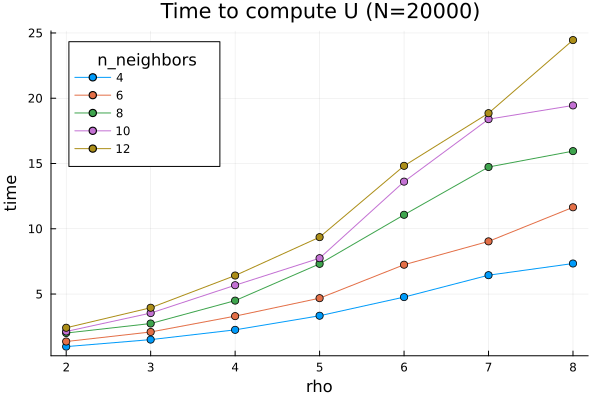

In [70]:
using Query

N_fixed = 20000

df |>
    @filter(_.N == N_fixed) |>
    @filter(_.n_neighbors % 2 == 0) |>
    @df plot(:rho, :time, group = :n_neighbors, xlabel = "rho", ylabel = "time", marker = :circle, 
    legend_title = "n_neighbors", title = "Time to compute U (N=$N_fixed)")


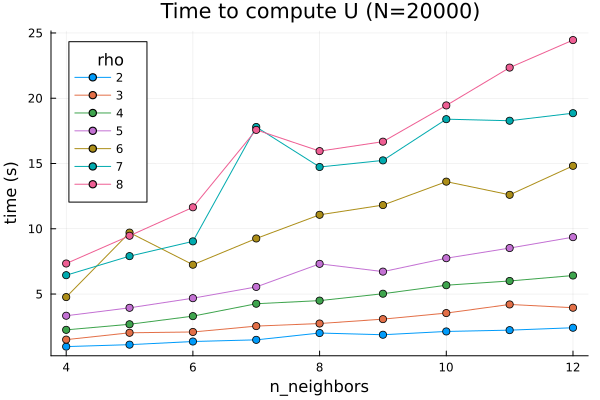

In [69]:
N_fixed = 20000

df |>
    @filter(_.N == N_fixed) |>
    @df plot(:n_neighbors, :time, group = :rho, xlabel = "n_neighbors", ylabel = "time (s)", marker = :circle, 
    legend_title = "rho", title = "Time to compute U (N=$N_fixed)")


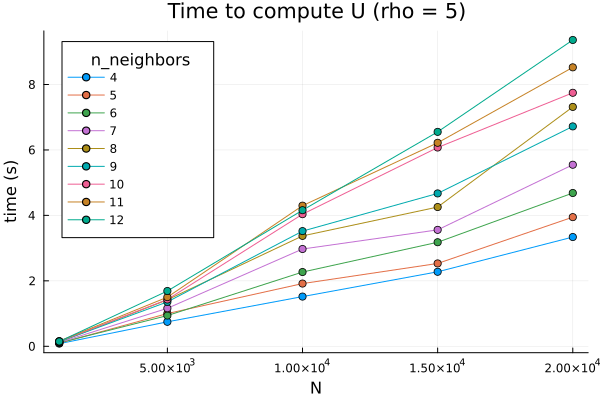

In [68]:
rho_fixed = 5


df |>
    @filter(_.rho == rho_fixed) |>
    @df plot(:N, :time, group = :n_neighbors, xlabel = "N", ylabel = "time (s)", marker = :circle, 
    legend_title = "n_neighbors", title = "Time to compute U (rho = $rho_fixed)")


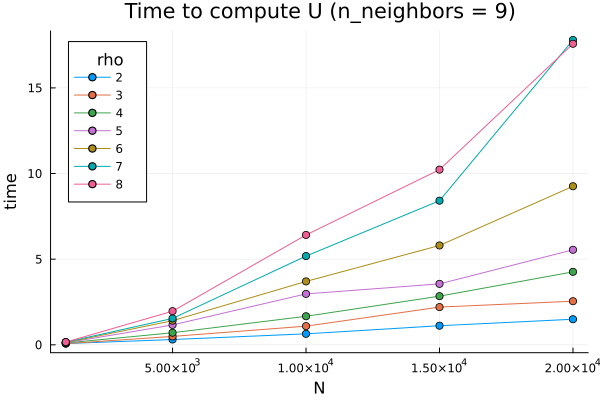

In [66]:
neighbors_fixed = 9

df |>
    @filter(_.n_neighbors == neighbors ) |>
    @df plot(:N, :time, group = :rho, xlabel = "N", ylabel = "time", marker = :circle, 
    legend_title = "rho", title = "Time to compute U (n_neighbors = $neighbors_fixed)")

My earlier filtering by hand before I had discovered groupby-function. Filter subsets where only one of the parameters N, rho, n_neighbors varies and other two are fixed

In [18]:
rho_N4_n10 = filter([:N, :n_neighbors] => (N, n) -> N == 10000 && n == 10, df)
rho_N4_n6 = filter([:N, :n_neighbors] => (N, n) -> N == 10000 && n == 6, df)
rho_N4_n8 = filter([:N, :n_neighbors] => (N, n) -> N == 10000 && n == 8, df)


Row,id,N,rho,n_neighbors,time
,Int64,Int64,Int64,Int64,Float64
1,131,10000,2,8,0.7802
2,140,10000,3,8,1.2684
3,149,10000,4,8,2.02604
4,158,10000,5,8,3.37386
5,167,10000,6,8,4.23383
6,176,10000,7,8,5.37821
7,185,10000,8,8,7.07673


## Accuracy

In [2]:


function acc_test(N::T, rhos::AbstractVector{T}, neighborss::AbstractVector{T}) where T<:Real
    # Tests for comparing accuracy of approximate Cholesky factorizations of Matern32 with l = [0.001] and different
    # values for rho, neighbors, N. Need to adjust this later to take also k and l as inputs so that they can also vary.
    # For some reason passing a funktion k didn't work
    df = DataFrame()
    l = [0.001]
    k = Matern32
    x = rand(2, N);
    K = kernel_matrix(x'[:,:],l,k);

    for neighbors in neighborss
        for rho in rhos
            factor = compute_explicit_factor(x, K, rho, neighbors)
            U_approx = factor.U
            P = factor.P
            C = cholesky(K[P, P])
            U = inv(C.U)
            abs_err = norm(U.-U_approx) #could try this with opnorm
            rel_err = abs_err/norm(U) #opnorm?
            push!(df, (N = N, rho = rho, n_neighbors = neighbors, U_approx = U_approx, P = P, abs_err = abs_err, rel_err = rel_err))
                
        end
    end
    return K, df

end




 


acc_test (generic function with 1 method)

In [3]:
N = 10000
rhos = 2:8
neighborss = [10]

K, df_acc = acc_test(N, rhos, neighborss)


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


[multithreading] using 1 threads


([1.0 0.9818921280184084 … 0.8627271613578794 0.8678759160298043; 0.9818921280184084 1.0 … 0.9077323185294389 0.9310100396790402; … ; 0.8627271613578794 0.9077323185294389 … 1.0 0.9278848840960836; 0.8678759160298043 0.9310100396790402 … 0.9278848840960836 1.0], 7×7 DataFrame
 Row │ N      rho    n_neighbors  U_approx                           P         ⋯
     │ Int64  Int64  Int64        SparseMa…                          Array…    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 10000      2           10  sparse([1, 1, 2, 1, 2, 3, 1, 2, …  [1, 2, 4, ⋯
   2 │ 10000      3           10  sparse([1, 1, 2, 1, 2, 3, 1, 2, …  [1, 2, 4,
   3 │ 10000      4           10  sparse([1, 1, 2, 1, 2, 3, 1, 2, …  [1, 2, 4,
   4 │ 10000      5           10  sparse([1, 1, 2, 1, 2, 3, 1, 2, …  [1, 2, 4,
   5 │ 10000      6           10  sparse([1, 1, 2, 1, 2, 3, 1, 2, …  [1, 2, 4, ⋯
   6 │ 10000      7           10  sparse([1, 1, 2, 1, 2, 3, 1, 2, …  [1, 2, 4,
  

5.477225575051661

5.464985704219043

# Examine the sparsity pattern of U_approx with different rho


* The left-hand upper corner of the matrix really dense with all rho
* Differences start to show when moving right. Also sparsity increases with all values of rho, but at different speeds


In [35]:
#The exact U

P = df_acc[1, :P]; #P same for each rho, only n_neighbors affects P. That's why I can just pick P from the fisrt row of df_acc


C = cholesky(K[P, P]);
U = inv(C.U)

10000×10000 LinearAlgebra.UpperTriangular{Float64, Matrix{Float64}}:
 1.0  -1.66332  -3.49968   -4.89489   …     -1.26876e-5      1.30859e-5
  ⋅    1.94078  -0.926512  -0.142445         4.00199e-6      7.78373e-7
  ⋅     ⋅        4.43442    2.9201          -2.88295e-6     -1.84232e-6
  ⋅     ⋅         ⋅         2.50712         -2.42284e-6     -2.8755e-6
  ⋅     ⋅         ⋅          ⋅              -2.79928e-5      7.47323e-6
  ⋅     ⋅         ⋅          ⋅        …      4.68615e-5     -2.17286e-5
  ⋅     ⋅         ⋅          ⋅              -1.4366e-5      -5.80237e-6
  ⋅     ⋅         ⋅          ⋅               8.46875e-5     -4.43838e-5
  ⋅     ⋅         ⋅          ⋅              -6.97517e-7      4.56289e-6
  ⋅     ⋅         ⋅          ⋅               9.21284e-7      9.95519e-6
 ⋮                                    ⋱                   
  ⋅     ⋅         ⋅          ⋅               0.000105404    -4.76008e-5
  ⋅     ⋅         ⋅          ⋅              -6.95257e-5      0.000152935
  ⋅     

In [26]:

#which rows and columns zoomed into
rows = 4950:5000
cols = 5000:5050

5000:5050

In [27]:
U_rho2 = df_acc[df_acc.rho .== 2, :U_approx][1];
U_rho2[rows, cols]


51×51 SparseArrays.SparseMatrixCSC{Float64, Int64} with 43 stored entries:
⎡⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠁⠀⡀⡀⠀⠐⠀⠐⠀⠀⠀⠀⎤
⎢⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠄⠀⠀⠀⎥
⎢⠀⠀⠀⠐⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠠⠀⠀⠀⠀⠄⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠁⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠈⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⎥
⎢⠀⠠⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠁⠀⠀⠀⠀⠀⡀⠀⠂⠁⠀⠀⠀⠀⎥
⎢⠀⠀⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠠⠁⠠⠀⠀⠀⠀⎥
⎢⠀⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠐⠀⠀⠀⠈⠀⠀⠀⎥
⎣⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠀⠀⠀⎦

In [30]:
U_rho5 = df_acc[df_acc.rho .== 5, :U_approx][1];
U_rho5[rows, cols]

51×51 SparseArrays.SparseMatrixCSC{Float64, Int64} with 288 stored entries:
⎡⡨⠨⠒⣀⠀⠀⠈⢄⣤⠀⡨⠅⠀⠐⢅⠀⡈⡀⠀⠐⠀⠐⠠⡀⡠⠀⎤
⎢⡀⠀⠊⣀⠈⠀⠐⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⢠⠐⡅⠈⠄⠀⠀⠀⎥
⎢⠢⠠⠀⠒⡠⠁⠠⠔⠀⠀⢂⢄⠀⡀⠄⠀⠢⠊⠐⠀⠀⠀⠠⠂⢀⠀⎥
⎢⠐⡖⠀⠀⠀⠈⠰⠀⠀⠈⢐⡆⠁⠀⠂⠈⠰⠀⡂⠀⠀⠀⠀⠀⠀⠁⎥
⎢⠀⠀⠍⠀⠀⠀⠀⢐⣒⠀⡂⠀⠀⠈⠀⠀⡂⡂⠀⠨⠀⠈⠀⡂⠐⠀⎥
⎢⠀⠀⠤⠀⢣⠐⢢⠀⠀⠑⠀⡘⠂⠡⠀⠀⢠⠀⠀⠠⠈⠢⠀⠐⠈⠀⎥
⎢⠠⠡⠂⠀⠀⠀⠈⠀⠀⠀⠠⠅⠀⠀⠄⠀⠨⠀⢄⠐⡀⠀⡀⠀⠠⠀⎥
⎢⢠⣠⠀⠀⠐⠈⢁⠆⠤⠈⢀⡄⠁⠀⡄⠈⢠⠀⡀⠀⠂⠁⠰⠈⠠⠁⎥
⎢⠀⠀⠦⠀⡈⠀⠐⠀⠀⠀⠀⢀⠀⡠⠀⠀⠀⠀⠈⠰⠁⠠⠁⠀⢀⠀⎥
⎢⠄⠂⢀⠠⢀⠌⢐⠀⠀⠈⠀⠂⠁⢀⠀⠈⢀⠠⠢⠀⠀⢀⠀⠀⠀⠁⎥
⎢⠀⠀⢀⠀⢆⠀⠀⡀⠒⠄⠈⠱⠀⢆⠀⠀⠀⠀⠁⠀⡠⢀⢀⠀⠰⠀⎥
⎢⠊⠈⠄⠒⠈⢀⡀⠁⠀⢀⠀⠀⡀⠀⠁⢀⠈⠀⠐⠠⠀⡀⠈⢀⠀⡀⎥
⎣⠄⠀⠀⠤⠀⠀⠀⠠⠀⠀⠄⠀⠘⠁⠠⠂⠄⠄⠀⠃⠀⠀⠀⠄⠄⠀⎦

In [31]:
U_rho8 = df_acc[df_acc.rho .== 8, :U_approx][1];
U_rho8[rows, cols]

51×51 SparseArrays.SparseMatrixCSC{Float64, Int64} with 729 stored entries:
⎡⣨⢭⠒⣀⣭⠀⠨⣥⣭⠀⡬⢭⠀⠝⣥⠀⣬⡄⢅⠐⠀⠐⢨⡄⢨⠀⎤
⎢⡀⢊⠛⣄⢈⠀⠐⣁⣉⠀⡀⠂⠀⠘⣁⠀⣈⡀⢢⠘⡅⠘⣍⡀⠀⠀⎥
⎢⢣⡴⠀⠛⡴⠃⢠⠖⠶⡀⢂⣤⢀⡠⠖⠀⠲⠚⡜⠀⠆⠀⠰⠂⢠⠀⎥
⎢⢐⡶⠀⠀⡲⠈⢱⠆⠶⠈⢐⣖⠁⡲⠆⠈⠰⠀⡆⠀⠈⠁⠰⠈⢑⠁⎥
⎢⣐⢐⠭⢀⣒⢀⡂⣒⣒⢀⡂⢐⡂⠨⣒⠀⣒⡂⠀⠨⢐⡪⢐⣒⣐⡂⎥
⎢⠘⣤⣤⠀⢣⠐⢣⡔⣤⠑⠊⡜⠋⢡⡔⠀⢢⠂⡄⢠⡜⢣⢠⠚⠚⠃⎥
⎢⠠⠭⠛⡀⠬⠀⠨⠅⠭⠀⠠⠥⠀⠼⠅⠀⠨⠀⢅⠘⡀⠘⡨⠀⠠⠀⎥
⎢⢠⣴⠒⠂⣴⠈⢡⡮⣶⠈⢥⣤⠁⣴⡮⠈⢵⠅⡔⠐⠊⠑⢲⠍⢡⠁⎥
⎢⢀⠚⠶⠁⡘⠀⡐⠃⠛⡀⢀⢂⣀⡸⠃⠀⠘⠀⠊⠰⢅⡰⠙⢀⢀⡀⎥
⎢⠄⣂⣀⠤⢀⠌⢑⡀⣀⠈⠀⡂⠁⢐⡀⠈⢀⠠⡢⢀⡈⢁⢄⠈⠁⠁⎥
⎢⠸⢑⣀⠀⢗⠀⠎⡒⣒⠆⠺⠹⠦⢇⡒⠁⢒⠂⠁⢁⡰⢆⣐⠲⠸⠆⎥
⎢⠊⠙⠤⠒⠙⢂⡈⠛⠛⢀⠃⠉⡀⠨⠛⢀⠛⠓⠑⠠⢃⡠⠚⢃⡈⡀⎥
⎣⠌⠀⠀⠤⠁⠠⠀⠠⠀⠣⠜⠈⠘⠃⠠⠃⠄⠄⠠⠃⠀⠀⠀⠄⠌⠀⎦

In [33]:
Array(U_rho8[rows, cols])

51×51 Matrix{Float64}:
   0.0          -9.80449e-6  -3.21392e-6  …   1.24417e-6   0.0
   0.0           0.0          0.0             0.0          0.0
   0.0          -0.799651    -1.49909e-6      8.73422e-7   0.0
   0.000595186  -3.685e-6     0.0            -4.49498e-7   0.0
   0.0           0.0          0.0             0.0          0.0
   0.0           0.0         -4.23676e-6  …   0.0          0.0
   0.0           0.0          0.0             0.0          0.0
   1.9401e-5     0.0          0.0             0.0          0.0
   2.47133e-6    0.0          0.0             0.0          0.0
  -0.0341928     0.0          0.0             0.0          0.0
   ⋮                                      ⋱                ⋮
   0.0           9.60072e-8   0.0             0.0449478   -3.90912e-5
   0.0           0.0          0.0             0.0          0.0
   0.0          -1.75154e-5  -1.37505e-6      9.74067e-7   0.0
  -3.06144e-5    0.0          0.0         …   0.0          0.0
   0.0           0.0       

In [36]:
U[rows, cols]

51×51 Matrix{Float64}:
   5.13454e-7   -1.69516e-5   -5.55061e-6   …   1.00971e-6  -1.23049e-6
  -2.27135e-6    3.08136e-5   -8.62855e-6       6.25613e-7  -7.19257e-7
  -4.26981e-7   -0.799654     -5.98868e-7       8.4763e-7   -4.78686e-7
   0.000595755  -2.33255e-6   -3.88318e-7      -9.36847e-7   3.08539e-7
  -6.88728e-7   -6.00071e-6   -3.33586e-6      -8.28161e-7  -6.41389e-8
  -3.38339e-7    1.16688e-6   -4.8022e-6    …  -8.32676e-7   2.15269e-6
   2.67063e-7    2.92668e-6    4.59667e-6      -2.95144e-6  -3.68127e-6
   1.32759e-5    1.78982e-5    2.30412e-6       8.71936e-6   8.7748e-6
  -1.61954e-6   -6.0251e-6    -1.6613e-6        3.37623e-6   1.41277e-6
  -0.0341931    -7.95364e-6    5.6151e-6       -2.78258e-6  -2.88306e-7
   ⋮                                        ⋱                ⋮
   1.32122e-6    2.42913e-7    3.02017e-6       0.044944    -4.49024e-5
   9.68773e-7   -4.11667e-7    2.7066e-7        5.72613e-7  -1.02131e-6
  -1.15417e-6   -1.33433e-5   -2.66689e-6       2.8

Exclude the matrices U_approx & P from df for clarity & speed of filtering

In [9]:
df_acc_S = select(df_acc, Not([:U_approx, :P]))

sort!(df_acc_S, :rel_err)

df_acc_S


Row,N,rho,n_neighbors,abs_err,rel_err
,Int64,Int64,Int64,Float64,Float64
1,10000,8,12,27.3308,4.8861e-5
2,10000,8,10,37.2001,6.65042e-5
3,10000,6,14,39.8596,7.12562e-5
4,10000,8,14,40.2689,7.19879e-5
5,10000,6,10,49.9782,8.9348e-5
6,10000,8,8,52.7082,9.42286e-5
7,10000,6,12,61.7813,0.00011045
8,10000,8,6,64.9194,0.00011606
9,10000,6,8,70.4538,0.000125953


In [10]:
using CSV
#CSV.write("out_sim_errs.csv", df_acc_S)

"out_sim_errs.csv"

In [96]:
#judging by the fact that below when comparing P created with different rho values but same n_neighbors, it seems that, P is dependant only on n_neighbors, not on rho

df_acc.P[2] == df_acc.P[17]

true

In [8]:
rho = 8
neighbors = 10

UP = filter([:rho, :n_neighbors] => (r, n) -> r==rho && n==4, df_acc)


0.000595250010436834

In [90]:
U_approx

10000×10000 Matrix{Float64}:
 1.0  -0.83534  -2.80066    -4.81513   …      0.0     0.0       0.0      0.0
 0.0   1.30299  -0.0626312  -0.941136         0.0     0.0       0.0      0.0
 0.0   0.0       3.01207     1.76183          0.0     0.0       0.0      0.0
 0.0   0.0       0.0         3.99221          0.0     0.0       0.0      0.0
 0.0   0.0       0.0         0.0              0.0     0.0       0.0      0.0
 0.0   0.0       0.0         0.0       …      0.0     0.0       0.0      0.0
 0.0   0.0       0.0         0.0              0.0     0.0       0.0      0.0
 0.0   0.0       0.0         0.0              0.0     0.0       0.0      0.0
 0.0   0.0       0.0         0.0              0.0     0.0       0.0      0.0
 0.0   0.0       0.0         0.0              0.0     0.0       0.0      0.0
 ⋮                                     ⋱                             
 0.0   0.0       0.0         0.0              0.0     0.0       0.0      0.0
 0.0   0.0       0.0         0.0              0.0     

┌ Warning: Skipped marker arg circle.
└ @ Plots /home/pietaril/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg circle.
└ @ Plots /home/pietaril/.julia/packages/Plots/rz1WP/src/args.jl:1148


┌ Warning: Skipped marker arg circle.
└ @ Plots /home/pietaril/.julia/packages/Plots/rz1WP/src/args.jl:1148


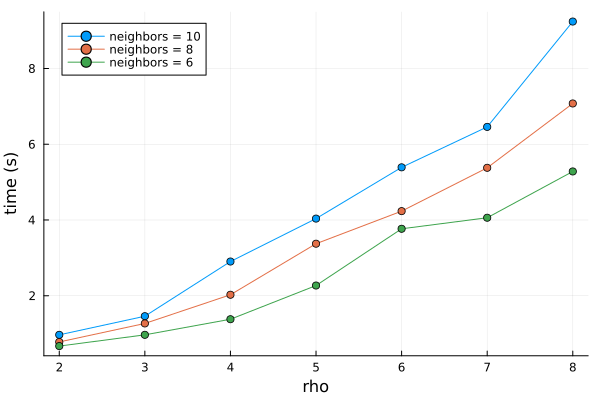

In [19]:

acc_rho = []
N = 10^4
 

UndefVarError: UndefVarError: `N_times` not defined